# TEXT CLASSIFICATION USING MULTILAYERED LSTM

## 1. Import statements

**Import necessary packages and modules**

In [1]:
import os
import time
import random
import math
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import progressbar
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Import gensim**

In [2]:
from gensim.models.word2vec import Word2VecKeyedVectors

**Set the random seed of numpy and tensorflow**

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


## 2. Load train data, test data, and gensim word2vec model

**Set some directories**

In [4]:
input_dir = "../input/"
word2vec_dir = "./word2vec_models/"
model_dir = "./model_files/"
submission_dir = "./submission/"

**Load the cleaned train and test data**

In [5]:
data = pd.read_csv(input_dir+'modified_train_data.csv', names = ["id", "text", "author", "length", "EAP", "HPL", "MWS"]) 
test_data = pd.read_csv(input_dir+'modified_test_data.csv', names = ["id", "text", "length"])

In [6]:
data.head(5)

,id,text,author,length,EAP,HPL,MWS
0,id26305,process howev afford mean ascertain dimens dun...,EAP,21,1,0,0
1,id17569,never occur fumbl might mere mistak,HPL,6,0,1,0
2,id11008,left hand gold snuff box caper hill cut manner...,EAP,19,1,0,0
3,id27763,love spring look windsor terrac sixteen fertil...,MWS,21,0,0,1
4,id12958,find noth els even gold superintend abandon at...,HPL,16,0,1,0


In [7]:
test_data.head(5)

,id,text,length
0,id02310,still urg leav ireland inquietud impati father...,10
1,id24541,fire want fan could readili fan newspap govern...,28
2,id00134,broken frail door found two clean pick human s...,17
3,id27757,think possibl manag without one actual tumbl h...,20
4,id04081,sure limit knowledg may extend,5


In [8]:
data = data.sample(frac=1,  random_state = np.random.seed()).reset_index(drop=True)
data = data[~data['text'].isnull()]
test_data = test_data[~test_data['text'].isnull()]

**Extract test ids**

In [9]:
test_ids = test_data.id.values

**Load metadata of word2vec model**

In [10]:
metadata= json.loads(open(word2vec_dir+"data.json").read())
size = metadata['size']

**Load the gensim word2vec model**

In [11]:
fname = "word2vec_model.mdl"
model = Word2VecKeyedVectors.load_word2vec_format(word2vec_dir+fname)

## 3. Distribution of authors in the train data

**Extract the number of examples of each class**

In [12]:
EAP_len = data[data['author'] == 'EAP'].shape[0]
HPL_len = data[data['author'] == 'HPL'].shape[0]
MWS_len = data[data['author'] == 'MWS'].shape[0]

**Bar chart of distribution authors**

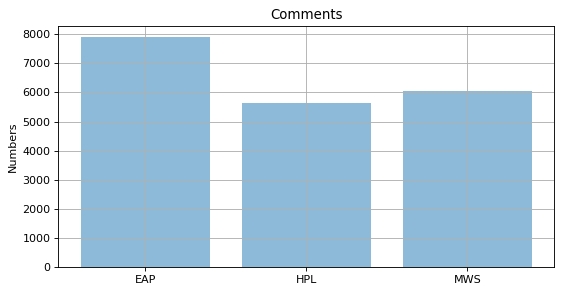

In [13]:
numbers = [EAP_len, HPL_len, MWS_len]
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(len(numbers)), numbers, align='center', alpha=0.5)
plt.xticks(np.arange(len(numbers)),\
           ['EAP', 'HPL', 'MWS'])
plt.ylabel('Numbers')
plt.title('Comments')
plt.grid()
plt.show()

## 4. Inspect the distribution of #words in the sentences

**Distribution of #words in train data**

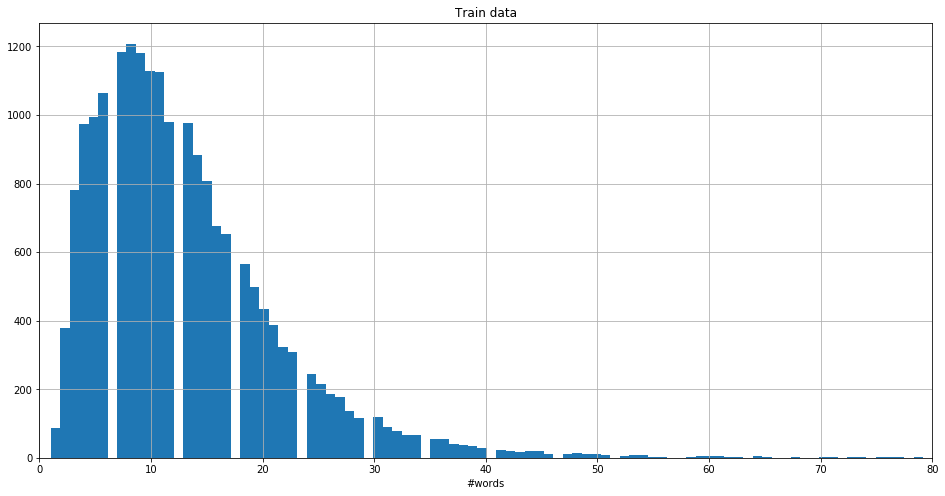

In [14]:
data.hist("length", bins=500, figsize=(16,8))
plt.title("Train data")
plt.xlabel("#words")
plt.xlim(0,80)
plt.show()

**Distribution of #words in test data**

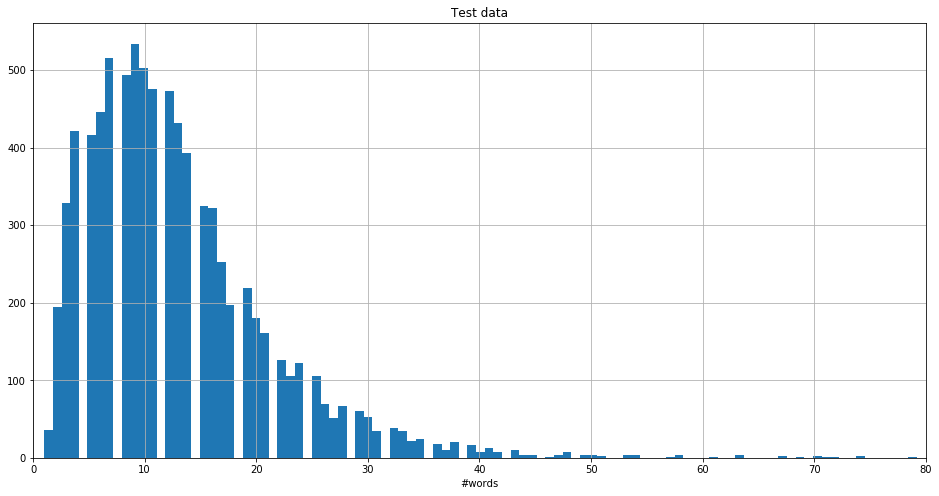

In [15]:
test_data.hist("length", bins=500, figsize=(16,8))
plt.title("Test data")
plt.xlabel("#words")
plt.xlim(0,80)
plt.show()

**Distribution of #words in all data**

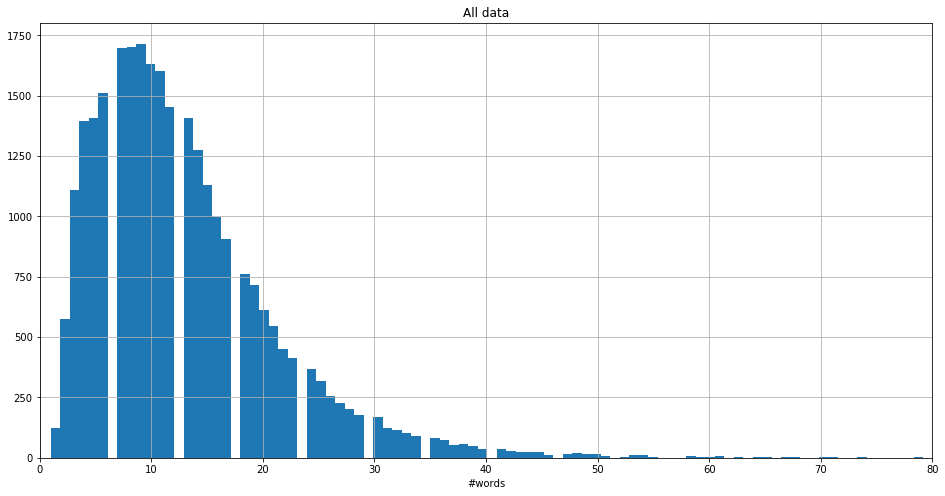

In [16]:
all_length = pd.concat([data['length'], test_data['length']])
all_length.hist(bins=500, figsize=(16,8))
plt.title("All data")
plt.xlim(0,80)
plt.xlabel("#words")
plt.show()
del(all_length)

**Split the training set into train and validation set and save the data if it is not already not saved**

In [17]:
test_data.to_csv(input_dir+"test_data.csv",header=True, index=False)
del(test_data)
if "train_data.csv" not in os.listdir(input_dir):
    train_data = data.head(int(len(data)*0.90))
    train_data.to_csv(input_dir+"train_data.csv",header=True, index=False)
    del(train_data)
valid_data = data.tail(len(data)-int(len(data)*0.90))
valid_size = len(valid_data)
if "valid_data.csv" not in os.listdir(input_dir):    
    valid_data.to_csv(input_dir+"valid_data.csv",header=True, index=False)
del(valid_data)
del(data)

## 5. Input functions

**A function to generate sequence of embeddings for the text columns**

In [18]:
def sequence_generator(comments, max_length, size):
    """
    A function to generate sequence of embeddings for the text columns
    """    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

**A function to generate batch of embeddings sequence, sequence length, and one hot encode output**

In [19]:
def generate_batch(reader, csv_path, batch_size, max_length, size, train_set=True):
    """
    A function to generate batch of embeddings sequence, sequence length, and one hot encode output
    """
    # read batch
    try:
        batch = reader.get_chunk()
    except:
        
        reader = pd.read_csv(csv_path, chunksize=batch_size)
        batch = reader.get_chunk()
    
    # extract columns of comments and sequence lengths
    comments_batch = batch["text"].values
    seq_length_batch = batch["length"].values
    # if it is train set then extract the columns of sentiments
    if train_set:
        authors = batch[["EAP","HPL","MWS"]].values
    # generate sequence of embeddings for the comments columns
    sequences_batch = sequence_generator(comments_batch, max_length, size)
    
    if train_set:
        return sequences_batch, seq_length_batch, authors
    else:
        return sequences_batch, seq_length_batch

## 6. Class module of multilayer lstm model

In [20]:
class multilayer_lstm_model(object):
    """
    Multilayer lstm model
    """    
    def __init__(self, n_steps, n_inputs, n_outputs, n_layers, 
                 n_neurons, dense_layers, learning_rate, device, tf_seed, np_seed):
        """
        Class constuctor which intializes the parameters, placeholders, and operations of the model
        """
        
        # parameters of lstm model
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.dense_layers = dense_layers
        self.learning_rate = learning_rate
        self.device = device
        self.tf_seed = tf_seed
        self.np_seed = np_seed    
        
        # placeholders and operations
        self.X = None
        self.Y = None
        self.Length = None
        self.keep_prob = None
        self.Y_ = None
        self.accuracy = None
        self.cost = None
        self.train_step = None
        
        # create model
        self.X, self.Y, self.Length, self.keep_prob, \
        self.Y_, self.accuracy, self.cost, self.train_step = self.create_model()
        
        self.saver = None
        self.train_cost = None
        self.valid_cost = None
        self.valid_accuracy = None
        self.best_valid_cost = None
        self.best_iteration = None
        self.best_time = None
        self.log_of_computation_time = []
        
        
    def create_model(self):
        """
        A method to create the multilayer lstm model
        """
        # placeholder to store the input of the model
        X = tf.placeholder(tf.float32, [None, self.n_steps, self.n_inputs])
        # placeholder to store the output of the model
        Y = tf.placeholder(tf.float32, [None, self.n_outputs])
        # placeholder to store the lengths of the sequences
        Length = tf.placeholder(tf.int32, [None])
        # keep probability for dropout
        keep_prob = tf.placeholder(tf.float32)
        
        # n layer of lstm cells
        lstm_cells = [tf.nn.rnn_cell.LSTMCell(num_units=self.n_neurons) 
                      for layer in range(self.n_layers)]
        # dropout applied to layers of lstm
        lstm_cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
                           for cell in lstm_cells]
        # mount lstm cells on gpu
        cells_across_gpu = [tf.nn.rnn_cell.DeviceWrapper(cell,self.device) 
                            for cell in lstm_cells_drop]
        # create a multilayer layer lstm cell
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(cells_across_gpu)
        # output and states of lstm
        outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32, sequence_length=Length)
        # extract the top layer h state
        top_layer_h_state = states[-1][1]
        
        # iterate and create the dense layer
        for n, dense_layer in enumerate(self.dense_layers):
            # first dense layer (with dropout)
            if n == 0:
                with tf.device(self.device):
                    dense = tf.layers.dense(top_layer_h_state, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
             # last dense layer (without dropout)
            elif n == len(self.dense_layers)-1:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer())
            # middle dense layers (with droput)
            else:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer, 
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
                    
        
        # softmax of output
        Y_pred = tf.nn.softmax(dense)
        # compute predicted class
        Y_ = tf.argmax(Y_pred, axis=1, output_type=tf.int32)
        # compute true class
        Y_true_cls = tf.argmax(Y, axis=1, output_type=tf.int32)
        # compute correct prediction
        correct_prediction = tf.equal(Y_, Y_true_cls)
        # compute accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # cost
        with tf.device(device):
            cost = tf.losses.log_loss(labels=Y,predictions=Y_pred)

        # train step
        with tf.device(device):
            train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)        
        
        return X, Y, Length, keep_prob, Y_, accuracy, cost, train_step
    
    
    def train_model(self, max_iter, batch_size, drop_prob,
                    train_data_reader,valid_data_reader,train_path, valid_path,
                    max_length, size, model_dir, model_name, generate_batch):
        """
        A method to train the multilayer lstm model
        """        
        # generate sequences, length, & sentimentas for validation set
        sequences_valid, seq_length_valid, authors_valid = \
        generate_batch(valid_data_reader, valid_path, valid_data_reader.chunksize,
                       self.n_steps, self.n_inputs)
        # feed dict for validation
        feed_dict_validation =  {self.X:sequences_valid,
                                 self.Y:authors_valid,
                                 self.Length:seq_length_valid,
                                 self.keep_prob: 1.0} 
        
        # start time
        start_time = time.time()
        # create a saver object
        saver = tf.train.Saver(max_to_keep=1)
        # lists to store the train cost, validation cost, and validation accuracy
        train_cost = []
        valid_cost = []
        valid_accuracy = []
        # variables to store the best roc and best iteration
        # and the time to reach the best roc
        best_valid_cost = 1e100
        best_iteration = None
        best_time = None
        # path of model saver object
        model_path = model_dir+model_name
        
        # create a graph session and optimize the network under it
        with tf.Session() as sess:
        
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            
            # create an object of progress bar
            bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
                '[',progressbar.Percentage(),']',
                progressbar.Bar(),
                '(',progressbar.DynamicMessage("train_cost"),')',
                '(',progressbar.DynamicMessage("valid_cost"),')',
                '(',progressbar.DynamicMessage("valid_accuracy"),')',
                '(',progressbar.DynamicMessage("best_valid_cost"),')',
                '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
            ])
            # start the progress bar
            bar.start()
            # counter variable to track the number of iterations
            counter = 0
            # iterate until maximum number of iterations is reached
            while True:
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break            
                # generate sequences, length, & sentimentas for validation set
                sequences_batch, seq_length_batch, authors_batch = \
                generate_batch(train_data_reader, train_path, batch_size, self.n_steps, self.n_inputs)
                # feed dict for validation
                feed_dict_batch =  {self.X:sequences_batch,
                                    self.Y:authors_batch,
                                    self.Length:seq_length_batch,
                                    self.keep_prob: drop_prob} 
                # execute optimization step
                sess.run(self.train_step, feed_dict=feed_dict_batch)
                # calculate temporary train cost and append it to the designated list
                temp_train_cost = self.cost.eval(session=sess, feed_dict=feed_dict_batch)
                train_cost.append(temp_train_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_cost = self.cost.eval(session=sess, feed_dict=feed_dict_validation)
                valid_cost.append(temp_valid_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_acc = self.accuracy.eval(session=sess, feed_dict=feed_dict_validation)
                valid_accuracy.append(temp_valid_acc)
                # compute running time from start point
                time_diff = (time.time()-start_time)/60
                # append elapsed time to the designated list
                self.log_of_computation_time.append(time_diff)
                # if valid cost is better than best recorded so far then
                # update the parameters of the best model and save the model
                if temp_valid_cost < best_valid_cost:
                    best_time = time_diff
                    best_valid_cost = temp_valid_cost
                    best_iteration = counter+1
                    saver.save(sess, model_path, global_step = best_iteration)
                    
                # store the required variables, placeholders and operations in designated class fields
                self.saver = saver
                self.train_cost = train_cost
                self.valid_cost = valid_cost
                self.best_valid_cost = best_valid_cost
                self.valid_accuracy = valid_accuracy
                self.best_iteration = best_iteration
                self.best_time = best_time

                # update the progress bar
                bar.update(counter+1, train_cost = temp_train_cost, 
                           valid_cost = temp_valid_cost,
                           valid_accuracy = temp_valid_acc, 
                           best_valid_cost = best_valid_cost, 
                           time_elapsed = time_diff)
                # increment counter variable
                counter += 1

            # finish the progress bar
            bar.finish()            
        
        
    def create_predictions(self, model_path, test_data_reader, test_path, 
                           test_ids, n_folds, submission_dir, submission_file):
        '''
        A function to compute predictions and submission file
        '''
        # submission path
        submission_path = submission_dir + submission_file

        with tf.Session() as sess: 
            # set random seed of tensorflow
            tf.set_random_seed(self.tf_seed)
            # restore the best model
            self.saver.restore(sess, model_path)
            # array to store the prediction
            preds = np.array([])
            # create a progress bar object
            bar = progressbar.ProgressBar(maxval=n_folds, widgets=[
                            '[',progressbar.Percentage(),']',
                            progressbar.Bar(),
                            '(',progressbar.DynamicMessage("number_of_folds_completed"),')'
                        ])            
            # start progress bat
            bar.start()
            
            # iterate through each fold
            for i in range(n_folds):
                # generate sequences, length, & sentiments for test set
                sequences_test, seq_length_test = \
                generate_batch(test_data_reader, test_path, test_data_reader.chunksize,
                               self.n_steps, self.n_inputs, train_set=False)
                # feed dict for test
                feed_dict_test =  {self.X:sequences_test,
                                   self.Length:seq_length_test,
                                   self.keep_prob: 1.0} 
                # evaluate predictions of the fold
                fold_preds = self.Y_.eval(session=sess, feed_dict = feed_dict_test)
                # append it to designated array
                preds = np.append(preds, fold_preds)                    
                # update the progress bar
                bar.update(i+1, number_of_folds_completed = i+1)                
            # finish the progress bar
            bar.finish()

            submission = pd.DataFrame({"id":test_ids, "author": preds})
            submission.to_csv(submission_path, header = True, index=False)

## 7. Create graph of multilayer lstm model

**Inspect the devices of kernel**

In [21]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14129038817298223515
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9029607498426212877
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Set the device to gpu if available**

In [22]:
if len(devices)>1:
    device = devices[-1].name
else:
    device = devices[0].name

**Reset the default graph**

In [23]:
tf.reset_default_graph()

**Create graph**

In [24]:
n_layers = 2
n_neurons = 32
max_length = n_steps = 50 
n_inputs = size
n_outputs = 3
dense_layers = [16,n_outputs]
learning_rate = (1e-5)*2
sequence_model = multilayer_lstm_model(n_steps, n_inputs, n_outputs, n_layers, 
                                       n_neurons, dense_layers, learning_rate,
                                       device, tf_rand_seed, np_rand_seed)

## 8. Train multilayer lstm model

**Train model**

In [25]:
max_iter = 1400
batch_size = 200
keep_prob = 0.50
train_path = input_dir+"train_data.csv"
train_data_reader = pd.read_csv(train_path, chunksize=batch_size)
valid_path = input_dir+"valid_data.csv"
valid_data_reader = pd.read_csv(valid_path, chunksize=valid_size)
model_name = "multilayer_lstm" 
sequence_model.train_model(max_iter, batch_size, keep_prob,
                           train_data_reader,valid_data_reader,train_path, valid_path,
                           max_length, size, model_dir, model_name, generate_batch)

[100%]||(train_cost:  0.328)(valid_cost:  0.445)(valid_accuracy:  0.712)(best_valid_cost:  0.441)(time_elapsed:   11.6mins)


**Plot of cost vs iterations**

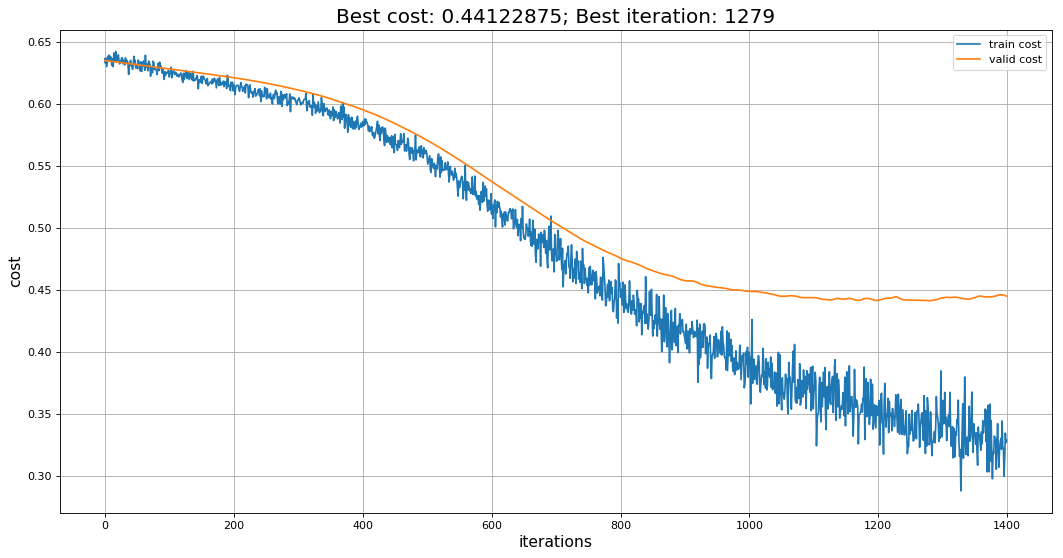

In [26]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.train_cost, label = 'train cost')
plt.plot(sequence_model.valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Best cost: "+str(sequence_model.best_valid_cost)+ \
          "; Best iteration: "+str(sequence_model.best_iteration),fontsize = 18)
plt.legend()
plt.grid()
plt.show()

**Plot of accuracy vs iterations**

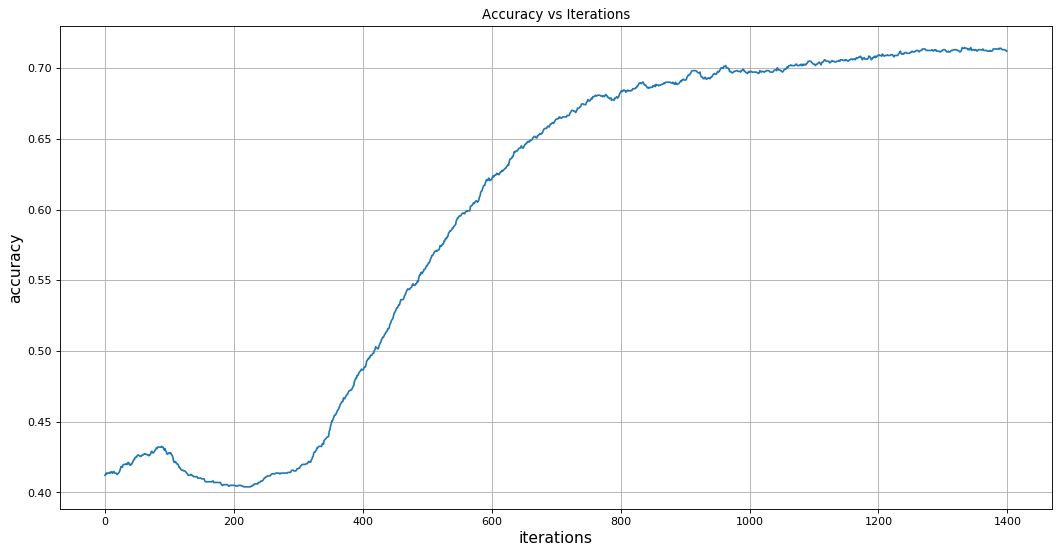

In [27]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.valid_accuracy)
plt.title("Accuracy vs Iterations")
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('accuracy', fontsize = 14)
plt.grid()
plt.show()

## 9. Create submission csv file

In [28]:
test_size = len(test_ids)
n_folds = 100
test_batch_size = test_size//n_folds
if test_size%n_folds != 0: n_folds +=2
submission_file = "submission.csv"
test_path = input_dir+"test_data.csv"
test_data_reader = pd.read_csv(test_path, chunksize=test_batch_size)
model_path = model_dir+model_name+"-"+str(sequence_model.best_iteration)
sequence_model.create_predictions(model_path, test_data_reader, test_path, 
                                   test_ids, n_folds, submission_dir, submission_file)

INFO:tensorflow:Restoring parameters from ./model_files/multilayer_lstm-1279


[100%]|####################################|(number_of_folds_completed:    101)


In [29]:
submission_file = pd.read_csv(submission_dir+submission_file)

In [30]:
submission_file.head(30)

,id,author
0,id02310,2.0
1,id24541,0.0
2,id00134,0.0
3,id27757,1.0
4,id04081,0.0
5,id27337,0.0
6,id24265,0.0
7,id25917,2.0
8,id04951,0.0
9,id14549,0.0
